# Data Assimilation

In [4]:
import os

import numpy as np
import torch

from src.assimilation.data_assimilation import DataAssimilation
from src.assimilation.train_pca import TrainPCA
from src.assimilation.utils import (
    augment_image,
    augment_images_in_sequence,
    create_augmented_array,
    plot_matrix_with_condition_number,
    covariance_matrix,
    modify_image_array,
)
from src.assimilation.cnn import CNNAutoencoder
from src.assimilation.decompression import (
    PCADecompressor,
    AutoencoderDecompressor,
    CAEDecompressor,
)
from src.forecasting.model import ImageSequencePredictor
from src.forecasting.generate_images import generate

# 1. Prepare Augmented Data for calucating PCA, B and R


To improve the numerical stability of B and R matrix in latent space, data augmentation technique are applied to generated images and observations so that to improve the condition number of B and R.

### 1.1 Data Augmentation for LSTM

#### Observation Data
- Rotate Observation to generate more data.
#### Model Data
- Use LSTM to predict more time steps and then rotate them.
#### PCA Training Data
- Augmented Observation Data + Model Data

#### Data Loading
* A user will need to download the wildfire data available at `https://companyname.sharepoint.com/sites/projectname/Shared%20Documents/example-document.docx`
* the current set up runs given that the `.npy` wildfire data is stored in a `data/` DIR.

In [6]:
#Load observation data
obs = np.load("../../../Ferguson_fire_obs.npy")
ag_obs = create_augmented_array(obs)
model_data = np.load("../../../Ferguson_fire_obs_with_generated.npy")
#last 10 data are predicted data
ag_model_data = create_augmented_array(model_data[5:15])
#PCA training data
pca_train_data = create_augmented_array(model_data)
#save them into npy
np.save("../../../gen_obs_for_R_55.npy.npy",ag_obs)
np.save("../../../gen_obs_for_B_110.npy",ag_model_data)
np.save("../../../gen_obs_for_pca.npy",pca_train_data)

### 1.2 Data Augmentation for VAE

#### Observation Data
- Rotate Observations to generate more data.
#### Model Data
- Use VAE to generate more images and then rotate them.
#### PCA Training Data
- Augmented Observation Data + Model Data

In [7]:
# ask objective 2 to save the generated data in some place
gen_obs = np.load('../../../task2_top_background_images.npy').astype(np.float32)
gen_obs_for_pca = create_augmented_array(gen_obs)
np.save("../../../task2_top_background_100.npy",gen_obs_for_pca)

# 2.Train PCA model for LSTM and VAE

### 2.1 Train PCA for LSTM

In [8]:
base_dir = '/Users/timdu/Desktop/Desktop - Tim’s MacBook Air/EDSML/acds3-wildfire-atlas/'

In [9]:
# need to find a better solution
train_file = os.path.join(base_dir, 'gen_obs_for_pca.npy')
obs_file = os.path.join(base_dir, 'Ferguson_fire_obs.npy')
background_file = os.path.join(base_dir, 'Ferguson_fire_background.npy')

Original MSE: 0.0426483154296875
Reduced MSE: 14.204610339796941


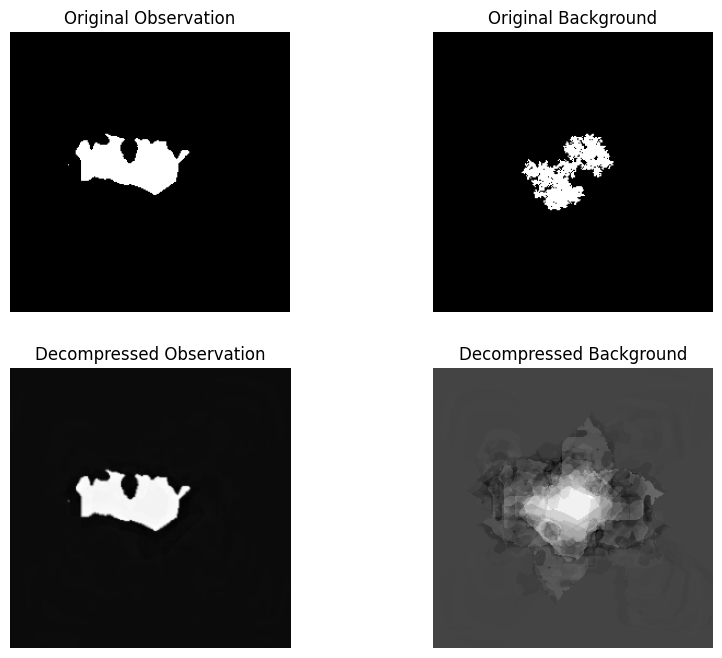

In [10]:
# train pca model for task1

pca_trainer = TrainPCA(train_file, 
                       obs_file, 
                       background_file, 
                       n_components=100,
                       obs_index=0, 
                       background_index=0)

pca_trainer.print_mse()
pca_trainer.save_model('pca_model_task1.pkl')
obs_reduced, background_reduced = pca_trainer.get_reduced_data()
pca_trainer.plot_images() 

### 2.2 Train CAE for VAE

In [11]:
test_file = os.path.join(base_dir, 'Ferguson_fire_test.npy')
cnn_model_path = os.path.join(base_dir, 'cnn_model.pth')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Original MSE: 0.0426483154296875
Reduced MSE: 14.204610339796941


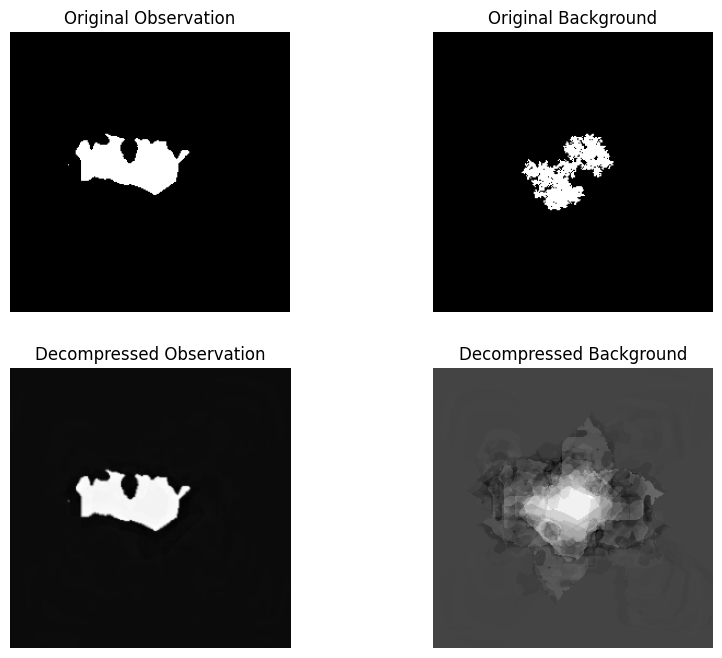

In [12]:
autoencoder = CNNAutoencoder(train_file, test_file, background_file, obs_file, device)

pca_trainer.print_mse()
pca_trainer.save_model('pca_model_task2.pkl')
obs_reduced, background_reduced = pca_trainer.get_reduced_data()
pca_trainer.plot_images() 
c_autoencoder_decompressor = CAEDecompressor(
    model_obj=autoencoder,
    model_path= cnn_model_path,
    device= device
)

# 3.Data Assimilation

### Data Assimilation Workflow

#### Setting up B and R Matrix
- The $\mathbf{B}$ and $\mathbf{R}$ matrices are error covariance matrices. We assume both of them are constant matrices, which means the measurement error do not change with time. The calucation of B is the covariance matrix of the model predicted(LSTM) or generated(VAE) images. R is the covariance matrix of oberservation image. Augmented historical data are used to better estimate numerically stable error covariance matrices. Although preferably, $\mathbf{B}$ and $\mathbf{R}$ should be calculated in the physical space, the huge image size makes the covariance matrix computation demanding. Therefore, we compress them into the latent space and calculate the covariance matrix there as the eigenvalues of the covariance matrix in the physical space, which indicate the variance along the principal components, are directly related to the variances in the latent space. The principal components (eigenvectors) align the data along axes of maximum variance, ensuring that the most critical variances are preserved during the dimensionality reduction. After checking the condition number of $\mathbf{B}$ and $\mathbf{R}$, we adjust the Regularization terms of $\mathbf{B}$ and $\mathbf{R}$ or approximate the covariance matrix to a diagonal form to improve the condition.

#### Regularization of B and R
- The regularization of $\mathbf{B}$ and $\mathbf{R}$ depends on their condition numbers. A matrix with a large condition number implies numerical instability and potential issues with trustworthiness. Higher values of regularization terms will be set to regularize the matrices.


### 3.1 DA on LSTM prediciton using PCA

In [13]:
# Initialize the decompressor
PCA1 = PCADecompressor('pca_model_task1.pkl')
back_last_file = os.path.join(base_dir, 'back_last.npy')
obs_file = os.path.join(base_dir, 'Ferguson_fire_obs.npy')
gen_obs_for_R_55_file = os.path.join(base_dir, 'gen_obs_for_R_55.npy')
gen_obs_for_B_110_file = os.path.join(base_dir, 'gen_obs_for_B_110.npy')

MSE (reduced before da): 4.006302170793252
MSE (full before da): 0.0087738037109375
MSE (reduced after da): 0.0014463474497106276
MSE (full after da): 0.000335693359375


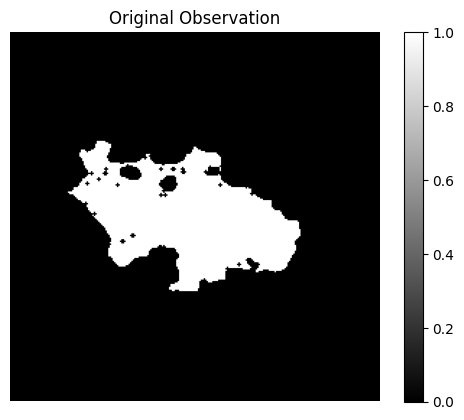

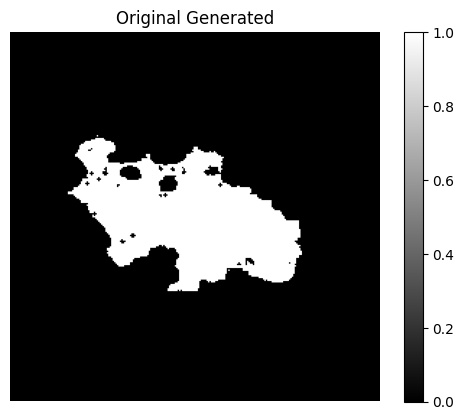

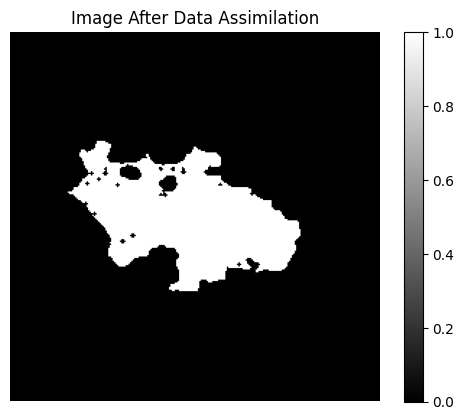

In [14]:
# apply data assimilation for result that from task1

from src.assimilation.data_assimilation import DataAssimilation

da = DataAssimilation(back_last_file, 
                      PCA1, 
                      obs_file, 
                      gen_obs_for_R_55_file,
                      gen_obs_for_B_110_file,
                      obs_index=-1,
                      W_B = 100,
                      W_R = 1,
                      latent_shape = 100)
da.assimilate()
da.print_mse()
da.plot_obs_image() 
da.plot_predicted_image()
da.plot_fixed_predicted_image()

#### 3.1.1 Choice of weight terms of B and R
1121/245

The condition number of the matrix is: 1136.1789334658804


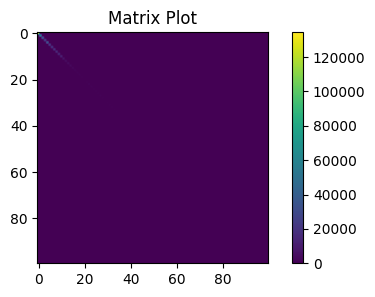

In [15]:
plot_matrix_with_condition_number(da.B)

The condition number of the matrix is: 219.42683660377884


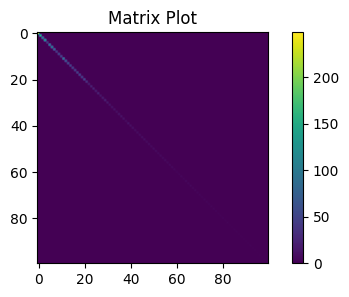

In [16]:
plot_matrix_with_condition_number(da.R)

 The B has a high condition number of approximately 1489, indicating potential numerical instability and sensitivity to perturbations. This is reflected in the graph, which shows large values concentrated in the diagonal, suggesting issues with scaling and accuracy. In contrast, the R matrix, with a reduced condition number of approximately 215, demonstrates enhanced numerical stability. The corresponding graph shows a more uniform distribution of values along the diagonal, indicating a more stable and reliable matrix. This improvement suggests that the second matrix is better conditioned, reducing the risk of numerical errors and improving the robustness of subsequent computations. Therefore, the weight of B and much higher than weight of R.

### 3.2 DA on VAE generated images compressed CAE

In [18]:
task2_best_background_assimilate_2_file = os.path.join(base_dir, 'task2_best_background_assimilate.npy')
obs_file = os.path.join(base_dir, 'Ferguson_fire_obs.npy')
gen_obs_for_R_55_file = os.path.join(base_dir, 'gen_obs_for_R_55.npy')
task2_top_background_100_file = os.path.join(base_dir, 'task2_top_background_100.npy')

In [19]:
da = DataAssimilation(task2_best_background_assimilate_2_file, 
                      c_autoencoder_decompressor, 
                      obs_file, 
                      gen_obs_for_R_55_file,
                      task2_top_background_100_file,
                      obs_index=0,
                      W_B=20,
                      latent_shape=32768)

da.assimilate()
da.print_mse()
da.plot_obs_image() 
da.plot_predicted_image()
da.plot_fixed_predicted_image()

### Continuously Correct model predictions with DA(3 images predict 1)

In [1]:
# create the model
input_dim = 64
hidden_dim = [128, 64]
kernel_size = (3, 3)
num_layers = 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
model = ImageSequencePredictor(input_dim, hidden_dim, kernel_size, num_layers)
model.load_state_dict(torch.load('../../../model_epoch_1.pth', map_location=device))

NameError: name 'torch' is not defined

#### First LSTM prediction on the 4th image

Test Mean Squared Error (MSE): 0.0005
Background Mean Squared Error (MSE): 0.0155
Obs Mean Squared Error (MSE): 0.0134


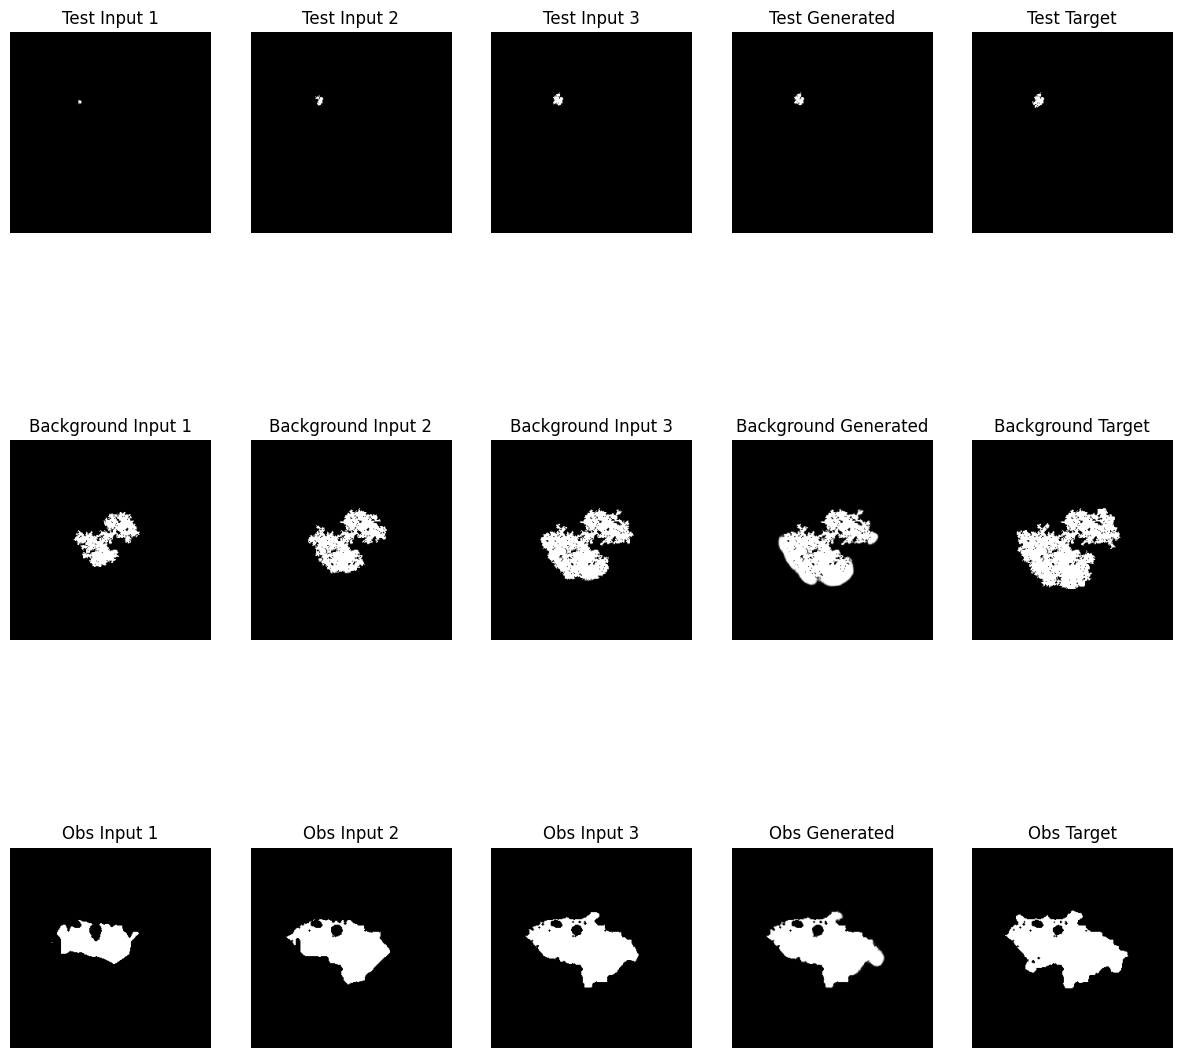

In [28]:
obs_data_0to4 = obs[0:4]
np.save('obs_data_0to4.npy', obs_data_0to4)
test_data = '../../../Ferguson_fire_test.npy'
background_data = '../../../Ferguson_fire_background.npy'
obs_data = 'obs_data_0to4.npy'
start=0
num_inputs=3
output_obs = generate(model, test_data, background_data, obs_data, start, num_inputs, device)
output_obs = np.array(output_obs)[-1]
np.save('../../../pred_4.npy', output_obs)

In [29]:
np.array(output_obs).shape

(256, 256)

Generated 4th image is an underestimate version of acutal images. The left downside wildfire are never spread furiously as between image 3 to 4. The lstm cannot predict that spreading withou data assimilation. Let's try how data assimialtion helps.

MSE (reduced before da): 6.658073206169518
MSE (full before da): 0.013280986610112405
MSE (reduced after da): 0.056331233030309964
MSE (full after da): 0.0001678466796875


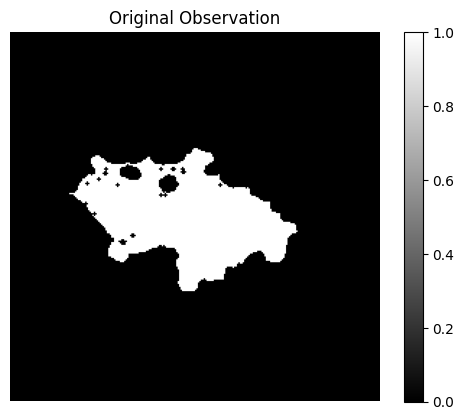

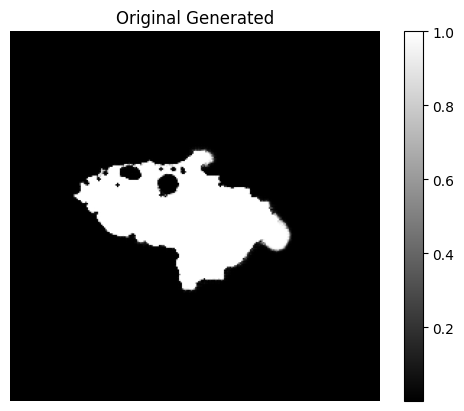

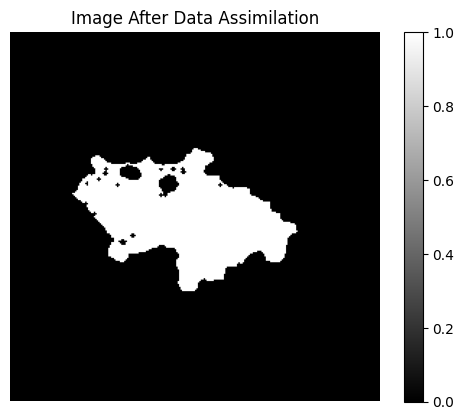

In [30]:
# Construct full file paths
pred_4_file = os.path.join(base_dir, 'pred_4.npy')
obs_file = os.path.join(base_dir, 'Ferguson_fire_obs.npy')
gen_obs_for_R_55_file = os.path.join(base_dir, 'gen_obs_for_R_55.npy')
gen_obs_for_B_110_file = os.path.join(base_dir, 'gen_obs_for_B_110.npy')


da = DataAssimilation(pred_4_file, PCA1, obs_file, gen_obs_for_R_55_file,gen_obs_for_B_110_file,obs_index=3,W_B = 20,latent_shape = 100)
da.assimilate()
da.print_mse()
da.plot_obs_image() 
da.plot_predicted_image()
da.plot_fixed_predicted_image()
da.save_predicted_image("../../../DA_image.npy")

In [31]:
DA_image = np.load('DA_image.npy')
obs_2to5 = modify_image_array(obs_data_0to4,DA_image,obs[-1])
obs_2to5 = np.append(obs_2to5, np.expand_dims(DA_image, axis=0), axis=0)
np.save('../../../obs_2to5.npy', obs_2to5)

Test Mean Squared Error (MSE): 0.0005
Background Mean Squared Error (MSE): 0.0155
Obs Mean Squared Error (MSE): 0.0131


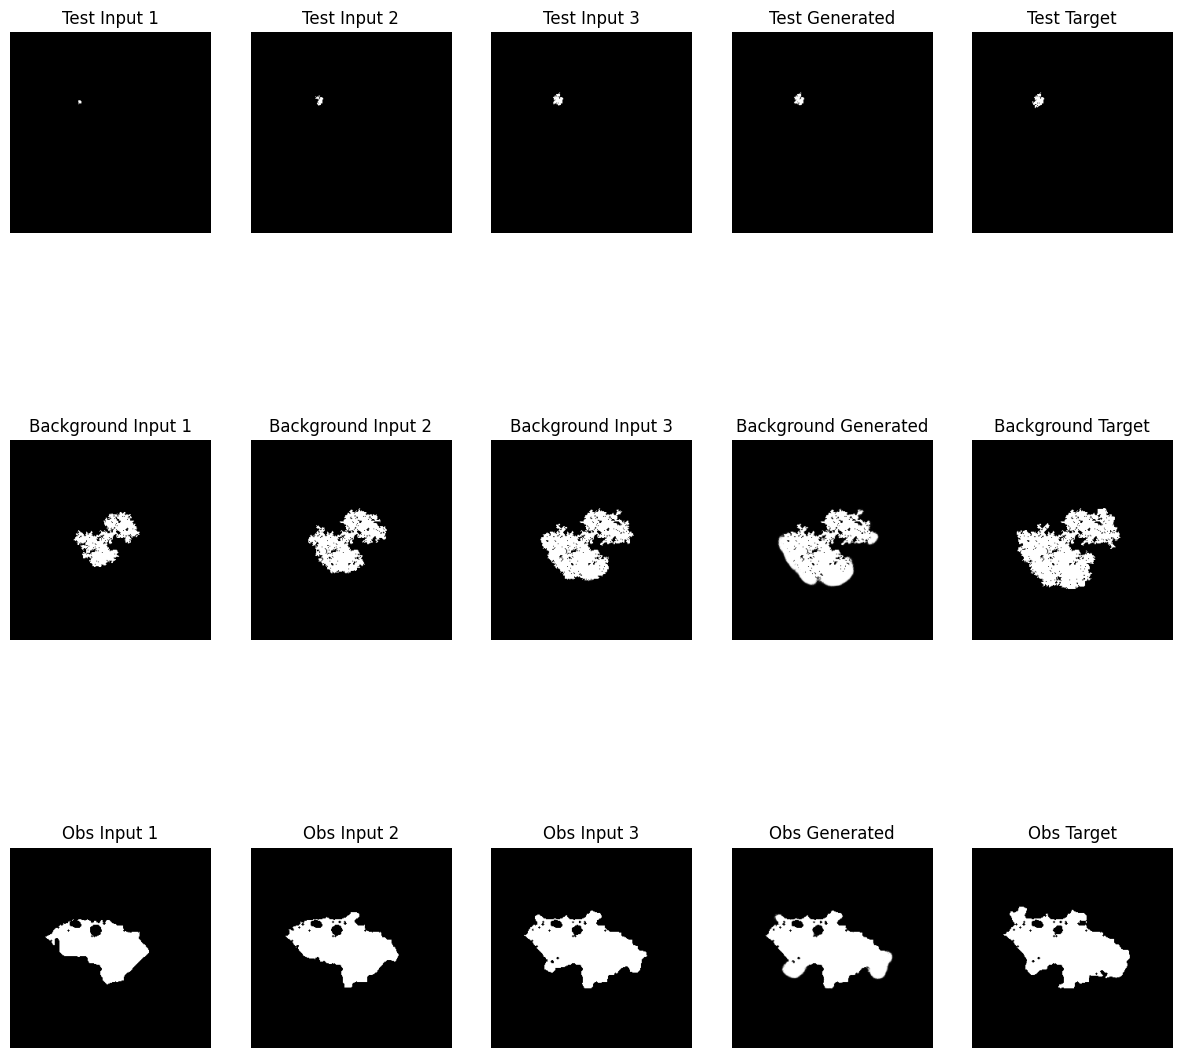

In [32]:
obs_2to5 = os.path.join(base_dir, 'obs_2to5.npy')
output2 = generate(model,test_data,background_data, obs_2to5, start, num_inputs, device)
np.save('../../../pred_5.npy', output2[-1])